In [24]:
import fastbook
fastbook.setup_book()
     

#hide
from fastbook import *
from fastai.vision.all import *

In [25]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=100):
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bear photos', max_images=1)
urls[0]

'https://www.publicdomainpictures.net/pictures/240000/velka/grizzly-bear-portrait-1511961987XRY.jpg'

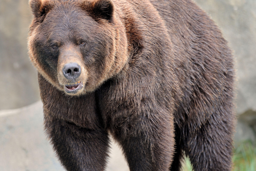

In [26]:
from fastai.vision.all import *
im = Image.open('images/bear.jpg')
im.to_thumb(256,256)

In [27]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [28]:
for o in bear_types:
    dest = (path/o)
    try:
        dest.mkdir(exist_ok=False, parents=True)
    except:
        continue
    download_images(dest, urls=search_images(f'{o} bears'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [29]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [30]:
fns = get_image_files(path)
fns

(#259) [Path('bears/black/02b33dfd-9c42-41d8-82e1-780f785351cf.jpg'),Path('bears/black/04b01682-da0b-4f64-901a-7884048c6927.jpg'),Path('bears/black/133d7165-8d09-4388-b6ce-b35d226eda2b.jpg'),Path('bears/black/15cc68cd-2790-44f2-a9f0-bbc600c8505c.jpg'),Path('bears/black/18779df7-45fb-48a8-b803-8d2b0cad77cb.jpg'),Path('bears/black/18d83e0b-d80b-403c-bc9c-0084119b479c.jpg'),Path('bears/black/1a77ff4f-b059-4ea7-ab50-54a3f4efc6fa.jpg'),Path('bears/black/1aa90350-35ab-4119-a491-d55998cfc88a.jpg'),Path('bears/black/1bc88ea3-3ab5-4445-89ec-762f780691ae.jpg'),Path('bears/black/1f1e86a9-c56a-4d56-ab54-ecbae11c51c1.jpg'),Path('bears/black/225588bf-8f86-4953-a595-6a88fbe3ce4a.jpg'),Path('bears/black/309e7d94-8ebf-40a9-a6fc-6d8ddc175df6.jpg'),Path('bears/black/30d2a36c-0f5d-4986-afb4-c85f8320ad69.jpg'),Path('bears/black/32b8d73c-2e0b-41ab-b8b7-0f314087e403.jpg'),Path('bears/black/36c2e8cd-39ae-400e-b6c6-c79c437ffa63.jpg'),Path('bears/black/37597fdf-e7f1-4e6a-bcf0-e3cf771cf69a.jpeg'),Path('bears/bla

In [31]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [32]:
dls = bears.dataloaders(path)

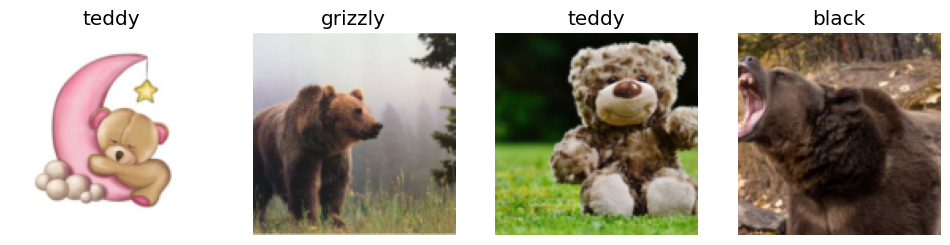

In [33]:
dls.valid.show_batch(max_n=4, nrows=1)

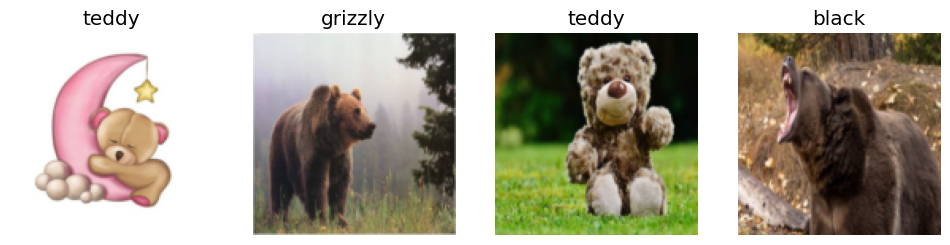

In [34]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

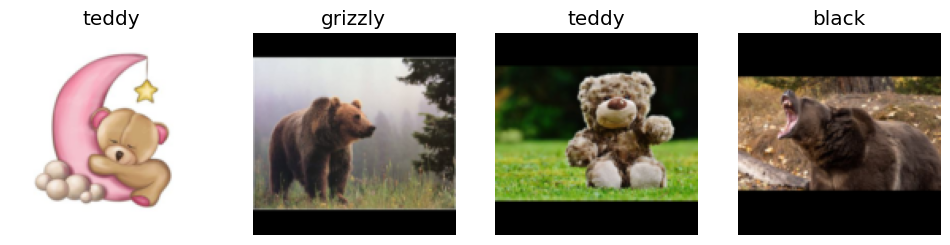

In [35]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

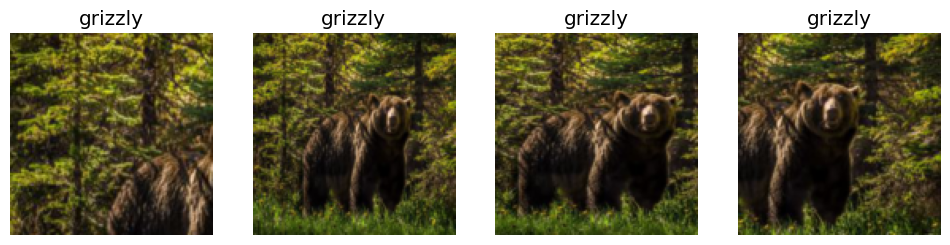

In [36]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

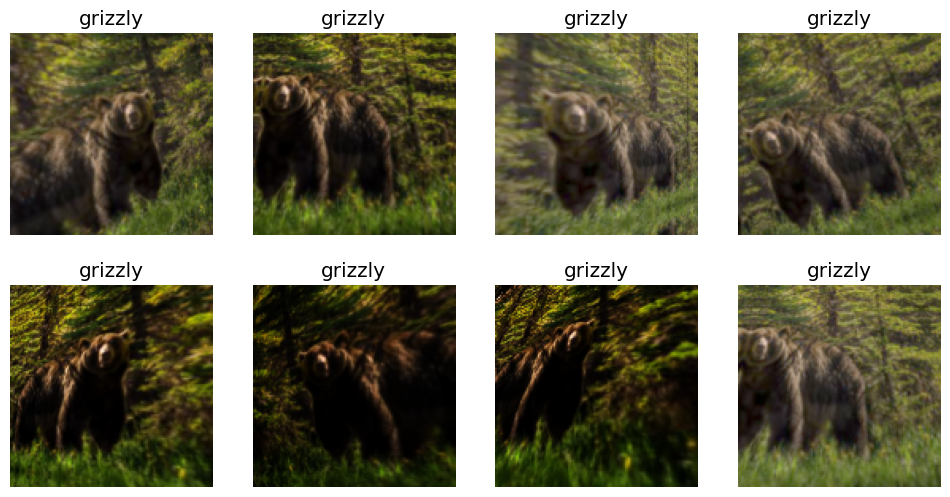

In [37]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [38]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

epoch,train_loss,valid_loss,error_rate,time
0,1.821324,0.290793,0.098039,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.415632,0.181261,0.058824,00:05
1,0.293572,0.172794,0.039216,00:05
2,0.235555,0.162755,0.039216,00:05
3,0.195537,0.161869,0.039216,00:05


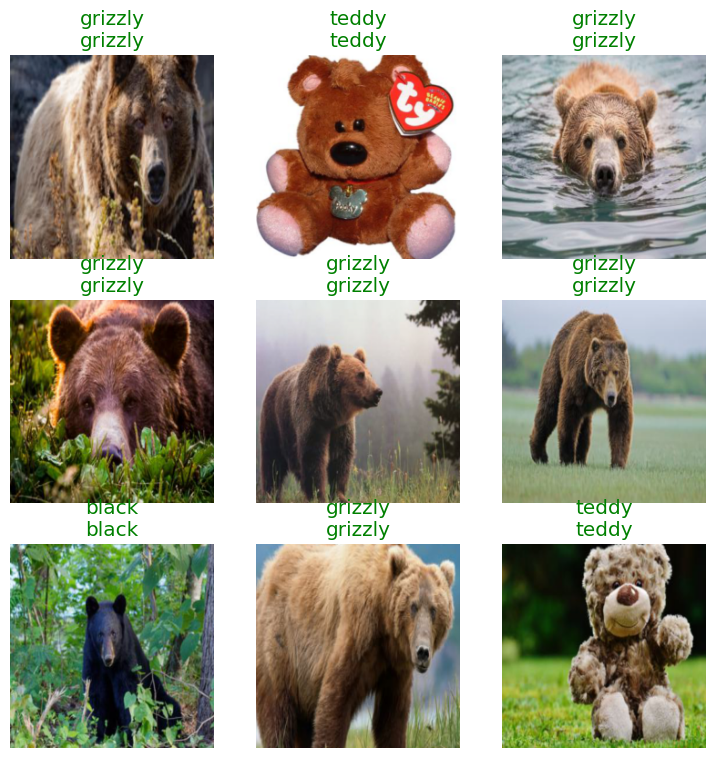

In [39]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)
learn.show_results()


Misclassified Examples:


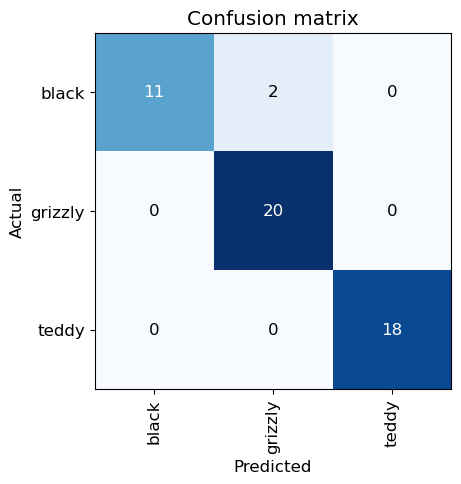

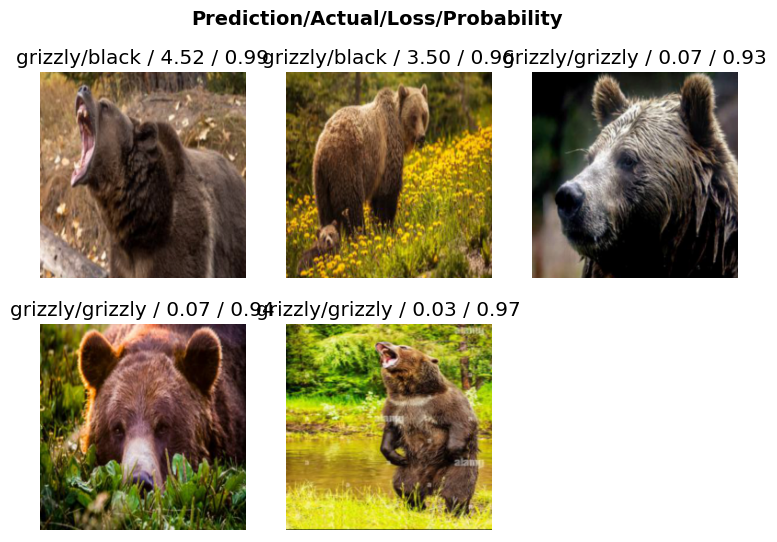

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

print("\nMisclassified Examples:")

interp.plot_top_losses(5, nrows=2)

In [41]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [42]:
# Take care. If this removes any images, the model will stop working.
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [43]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

learn.export()

pathlib.PosixPath = temp  # Reset PosixPath to its original state

In [44]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [45]:
learn_inf = load_learner(path/'export.pkl')

In [46]:
learn_inf.predict('images/bear.jpg')

('grizzly', tensor(1), tensor([0.0109, 0.9880, 0.0010]))

In [47]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']